using temporal affinity fields to increase pose estimation accuracy


In [1]:
#mounting drive to access drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#tokenpose_L_D24_256_192_patch43_dim192_depth24_heads12.yaml

%cd /content/drive/MyDrive/*learning2022/research_project/TokenPose/experiments/h36

/content/drive/MyDrive/*learning2022/research_project/TokenPose/experiments/h36


In [ ]:
!touch tokenpose_mod_L_D24_256_192_patch43_dim192_depth24_heads12.yaml

In [ ]:
import torch
output = torch.rand(25,17,68, 48)
print(range(list(output.shape[1])))

range(0, 17)


In [ ]:
#gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun  8 19:57:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Training & testing tokenpose

In [2]:
%cd /content/drive/MyDrive/*learning2022/research_project/TokenPose
!pip install -r requirements.txt
!pip install -Uqq ipdb #debugging tool use command ipdb.set_trace()

/content/drive/MyDrive/*learning2022/research_project/TokenPose
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd lib/models/

/content/drive/MyDrive/*learning2022/research_project/TokenPose/lib/models


In [ ]:
#tools

#checking if file path exists
import os.path
os.path.isfile('pose_tokenpose_l_taf.py') 

True

In [ ]:
!pwd

/content/drive/MyDrive/*learning2022/research_project/TokenPose


In [112]:
#training on Tokenpose with taf

!python tools/train.py \
    --cfg experiments/h36/tokenpose_mod_L_D24_256_192_patch43_dim192_depth24_heads12.yaml

=> creating output/h36/pose_tokenpose_l_taf/tokenpose_mod_L_D24_256_192_patch43_dim192_depth24_heads12
=> creating log/h36/pose_tokenpose_l_taf/tokenpose_mod_L_D24_256_192_patch43_dim192_depth24_heads12_2022-07-08-03-19
Namespace(cfg='experiments/h36/tokenpose_mod_L_D24_256_192_patch43_dim192_depth24_heads12.yaml', dataDir='', logDir='', modelDir='', opts=[], prevModelDir='')
AUTO_RESUME: True
CUDNN:
  BENCHMARK: True
  DETERMINISTIC: False
  ENABLED: True
DATASET:
  COLOR_RGB: True
  DATASET: h36
  DATA_FORMAT: jpg
  FLIP: True
  HYBRID_JOINTS_TYPE: 
  NUM_JOINTS_HALF_BODY: 8
  PROB_HALF_BODY: 0.3
  ROOT: /content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/H36_video_data/
  ROT_FACTOR: 45
  SCALE_FACTOR: 0.35
  SELECT_DATA: False
  TEST_SET: test_set
  TRAIN_SET: train_set
DATA_DIR: 
DEBUG:
  DEBUG: True
  SAVE_BATCH_IMAGES_GT: True
  SAVE_BATCH_IMAGES_PRED: True
  SAVE_HEATMAPS_GT: True
  SAVE_HEATMAPS_PRED: True
GPUS: (0,)
LOG_DIR: log
LOSS:
  TOPK: 8
  USE_DIFFER

In [110]:
import torch

#x = torch.rand(((4,3,2)))#(25,17, 2)
x = torch.tensor([[[1.,15],[2.,1.1],[2.,1.]],
                  [[1.,2],[2.,1.2],[2.,1.]],
                  [[1.,2],[2.,1.3],[2.,1.]],
                  [[1.,2],[2.,1.4],[2.,1.]]]) #(4,3,2)
                  #affecting one number only affects the corresponding num in each "row"
print(x.shape) #[4, 3, 2]
x2 = torch.norm(x, dim=2)
print(x2.shape) #[4, 3]
print(x2)
output = torch.mean(x2)
print(output)

torch.Size([4, 3, 2])
torch.Size([4, 3])
tensor([[15.0333,  2.2825,  2.2361],
        [ 2.2361,  2.3324,  2.2361],
        [ 2.2361,  2.3854,  2.2361],
        [ 2.2361,  2.4413,  2.2361]])
tensor(3.3439)


In [74]:
import torch
output = torch.rand((25,17,64,48,2))
y = output.reshape((output.size(0), output.size(1), -1))
y1 = y.split(1, 0) # split size, split dimension
print(y.shape)
print(len(y1))
print(y1[2].shape)

torch.Size([25, 17, 3072])
25
torch.Size([1, 17, 3072])


In [60]:
from einops import rearrange, repeat
num= 64*48*2
output = torch.rand((25,17,num))
taf = rearrange(output,'b c (p1 p2 p3) -> b c p1 p2 p3',p1=64,p2=48,p3=2)
print(taf.shape)

torch.Size([25, 17, 64, 48, 2])


In [71]:
x = [1,2,3]
print(x[:-1])

[1, 2]


In [30]:
import torch
import numpy as np

def downsize_old(input_heatmap): #(shape is 1000, 1000)
    downsized_input_heatmap = np.zeros((int(input_heatmap.shape[0]/2), int(input_heatmap.shape[1]/2)))
    for rows in range(len(input_heatmap)):
      if rows % 2 == 1:
        continue
      for columns in range(len(input_heatmap[rows])):
        if columns% 2 == 1:
          continue
        downsized_input_heatmap[math.floor(rows/2)][math.floor(columns/2)] = input_heatmap[rows][columns]
        
    return downsized_input_heatmap

def downsize_newer(input_heatmap):
  downsized_input_heatmap = np.zeros((int(input_heatmap.shape[0]/2), int(input_heatmap.shape[1]/2)))
  for r, row in enumerate(range(input_heatmap.shape[0])[::2]):
    for c, col in enumerate(range(input_heatmap.shape[1])[::2]):
      downsized_input_heatmap[r][c] = input_heatmap[row][col]
  return downsized_input_heatmap

def downsize(input_heatmap):
  downsized_input_heatmap = input_heatmap
  for i in range(int(input_heatmap.shape[0]/2)):
    downsized_input_heatmap = downsized_input_heatmap.pop(i)
    for j in range(int(input_heatmap.shape[1]/2)):
      downsized_input_heatmap = downsized_input_heatmap.pop(j)
  return downsized_input_heatmap

x1 = torch.rand((4,2))
x = downsize_newer(x1)
print(x1.shape)
print(x.shape)
print(x1)
print(x)

torch.Size([4, 2])
(2, 1)
tensor([[0.8961, 0.9057],
        [0.5803, 0.6339],
        [0.2048, 0.3135],
        [0.6471, 0.0543]])
[[0.89613444]
 [0.20483941]]


In [ ]:
import torch 
x = torch.tensor([[[1,6],[4,1]],
                  [[2,9],[3,0]]])
print(x[1,1,0])
'''
for idx, kpt in enumerate(x):
  print(idx)
  print(kpt.shape)
'''

tensor(3)


'\nfor idx, kpt in enumerate(x):\n  print(idx)\n  print(kpt.shape)\n'

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import normalize

#target = torch.rand(17,1000,1000)

x = torch.tensor([[1.1857485e-33, 2.7657210e-34, 5.0240106e-35, 7.1075365e-36, 7.8309419e-37,
  6.7194744e-38, 4.4903446e-39, 2.3369735e-40, 9.4727776e-42, 2.9847657e-43,
  7.0064923e-45, 0.0000000e+00, 0.0000000e+00],
 [2.5644366e-36, 5.9814678e-37, 1.0865505e-37, 1.5371579e-38, 1.6936093e-39,
  1.4532306e-40, 9.7109984e-42, 5.0586875e-43, 2.1019477e-44, 0.0000000e+00,
  0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
 [4.3193428e-39, 1.0074733e-39, 1.8301098e-40, 2.5890390e-41, 2.8530437e-42,
  2.4522723e-43, 1.6815582e-44, 1.4012985e-45, 0.0000000e+00, 0.0000000e+00,
  0.0000000e+00, 0.0000000e+00, 0.0000000e+00]])
#x = [[23,3],[26,4]]
target2 = (x - np.min(x)) / (np.max(x) - np.min(x))
#target2 = target2*1e36
print(target2)
target2 = np.linalg.norm(target2)
print(target2.shape)

#target= target[0,395:405,620:630]

#plt.imshow(target2, cmap='hot', interpolation='nearest')
#plt.show()
#plt.savefig('/content/drive/MyDrive/foo.png')

In [ ]:
dicts = {
    '11':1,
    '22':2
}

for i in dicts:
  print(i)

11
22


In [ ]:
import math
import numpy as np

def downsize_old(input_heatmap): #(shape is 17, 1000, 1000)
    downsized_input_heatmap= np.zeros((int(input_heatmap.shape[0]), int(input_heatmap.shape[1]/2), int(input_heatmap.shape[2]/2)))
    for joint in range(len(input_heatmap)):
      for rows in range(len(input_heatmap[joint])):
        if rows % 2 == 1:
          continue
        for columns in range(len(input_heatmap[joint][rows])):
          if columns% 2 == 1:
            continue
          downsized_input_heatmap[joint][math.floor(rows/2)][math.floor(columns/2)] = input_heatmap[joint][rows][columns]
          
    return downsized_input_heatmap

def downsize(input_heatmap): #(shape is 1000, 1000)
  downsized_input_heatmap = np.zeros((int(input_heatmap.shape[0]/2), int(input_heatmap.shape[1]/2)))
  for rows in range(len(input_heatmap)):
    if rows % 2 == 1:
      continue
    for columns in range(len(input_heatmap[rows])):
      if columns% 2 == 1:
        continue
      downsized_input_heatmap[math.floor(rows/2)][math.floor(columns/2)] = input_heatmap[rows][columns]
      
  return downsized_input_heatmap

x = np.random.rand(10,10)

x1 = downsize(x)
print(x1.shape)
print('x:',x)
print('x1:',x1)


(5, 5)
x: [[9.90186415e-01 1.88622078e-02 1.10957140e-01 7.45515541e-01
  4.24130756e-01 8.18382962e-01 2.67255635e-01 1.53986163e-01
  9.07428559e-01 3.06302913e-01]
 [5.02804775e-01 1.35228914e-01 9.73416928e-01 3.91422781e-03
  4.99896928e-01 8.08394612e-01 1.76668516e-01 5.67677647e-01
  1.28245306e-01 2.89328624e-01]
 [9.51094397e-01 1.62744972e-01 5.04770856e-01 4.97690312e-01
  5.07753746e-01 8.55680544e-01 2.92178997e-01 6.12301456e-01
  1.69043432e-01 3.54808331e-01]
 [2.18617491e-01 7.25816595e-01 3.52293816e-01 6.60498935e-01
  1.11650790e-01 5.62318606e-01 2.24824278e-01 7.24055261e-01
  5.09874187e-01 6.92715705e-01]
 [9.14556077e-01 2.31727413e-01 4.38883410e-01 8.85109623e-01
  7.57448048e-01 4.86485191e-03 8.05896665e-01 9.30378192e-01
  3.86775232e-01 4.58527817e-01]
 [1.65013164e-01 3.03355276e-02 1.24287465e-01 3.57076891e-01
  2.02201163e-01 9.92856186e-01 4.38924949e-01 6.24503840e-01
  8.97001362e-01 7.17127718e-01]
 [4.13858464e-01 7.55158224e-01 2.93716166e-01 6

In [ ]:
import torch
import numpy as np

x = torch.tensor([[2,3,1],[2,3,4],[1,1,1],[2,3,4]]) 
print(x.size())  #prints out an array of the size
print(x.shape) #is an alias of z.size
print(x.size(1)) #prints out the 0th dimension shape
y = torch.rand((25,17,3))
all_preds = np.zeros(
        (25, 17, 3),
        dtype=np.float32
    )
print(all_preds[1:1 + 25, :,0:2].shape)
print(all_preds[25:25 + 25, :,0:2].shape)

torch.Size([4, 3])
torch.Size([4, 3])
3
(24, 17, 2)
(0, 17, 2)


In [ ]:
import torch
import numpy as np
center = torch.zeros(17, 2)
for i in range(len(center)):
  center[i][0] = 128
  center[i][1] = 98
print(center)
#print(torch.ones(17,2))
print(np.array([0, 0], dtype=np.float32))


tensor([[128.,  98.],
        [128.,  98.],
        [128.,  98.],
        [128.,  98.],
        [128.,  98.],
        [128.,  98.],
        [128.,  98.],
        [128.,  98.],
        [128.,  98.],
        [128.,  98.],
        [128.,  98.],
        [128.,  98.],
        [128.,  98.],
        [128.,  98.],
        [128.,  98.],
        [128.,  98.],
        [128.,  98.]])
[0. 0.]


In [ ]:
#   "Cannot re-initialize CUDA in forked subprocess. To use CUDA with "
# RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


#RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [12, 250, 256, 192, 3]


#RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[250, 256, 192, 3] to have 3 channels, but got 256 channels instead

#RuntimeError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 15.78 GiB total capacity; 14.29 GiB already allocated; 52.75 MiB free; 14.32 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#all_preds[idx:idx + num_images, :, 0:2] = preds[:, :, 0:2]
#ValueError: could not broadcast input array from shape (25,17,2) into shape (0,17,2)

In [ ]:
import torch

x = torch.rand(25,17,64,48)
x = x.reshape((25,17, -1)) #torch.Size([25, 17, 3072])
x = x.split(1,1) #concatenate all the 17 into 1

y = torch.rand(2,2,2,2)

y = y.reshape((1,1, -1)) #torch.Size([25, 17, 3072])
y = y.split(1,1)
print(x[0].shape)


torch.Size([25, 1, 3072])


In [ ]:
'''x = 'as232323'
print(x[2:])

'''
import pathlib
vid_name = 'S1_000007_Greeting 1.58860488.mp4'
vid_name_wo_mp4 = pathlib.Path(vid_name).with_suffix(".mp4").stem
print(vid_name_wo_mp4)

S1_000007_Greeting 1.58860488


In [ ]:
import numpy as np
positions_2d_path = '/content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/data_2d_h36m_gt.npz'
loaded_data = np.load(positions_2d_path, allow_pickle=True) #dict
    
subject_list = loaded_data['positions_2d'].tolist().keys() 

values = loaded_data['positions_2d'].tolist()['S1']['Directions 1']
print(len(values))
'''
for subject in subject_list:
  action_list = loaded_data['positions_2d'].tolist()[subject].keys()
print(subject_list)
'''

4


"\nfor subject in subject_list:\n  action_list = loaded_data['positions_2d'].tolist()[subject].keys()\nprint(subject_list)\n"

In [ ]:
#training on old Tokenpose

!python tools/train.py \
    --cfg experiments/coco/tokenpose/tokenpose_L_D24_256_192_patch43_dim192_depth24_heads12.yaml

=> creating output/coco/pose_tokenpose_l/tokenpose_L_D24_256_192_patch43_dim192_depth24_heads12
=> creating log/coco/pose_tokenpose_l/tokenpose_L_D24_256_192_patch43_dim192_depth24_heads12_2022-07-06-00-05
Namespace(cfg='experiments/coco/tokenpose/tokenpose_L_D24_256_192_patch43_dim192_depth24_heads12.yaml', dataDir='', logDir='', modelDir='', opts=[], prevModelDir='')
AUTO_RESUME: True
CUDNN:
  BENCHMARK: True
  DETERMINISTIC: False
  ENABLED: True
DATASET:
  COLOR_RGB: True
  DATASET: coco
  DATA_FORMAT: jpg
  FLIP: True
  HYBRID_JOINTS_TYPE: 
  NUM_JOINTS_HALF_BODY: 8
  PROB_HALF_BODY: 0.3
  ROOT: /data/dataset/COCO_2017
  ROT_FACTOR: 45
  SCALE_FACTOR: 0.35
  SELECT_DATA: False
  TEST_SET: val2017
  TRAIN_SET: train2017
DATA_DIR: 
DEBUG:
  DEBUG: True
  SAVE_BATCH_IMAGES_GT: True
  SAVE_BATCH_IMAGES_PRED: True
  SAVE_HEATMAPS_GT: True
  SAVE_HEATMAPS_PRED: True
GPUS: (0, 1, 2, 3)
LOG_DIR: log
LOSS:
  TOPK: 8
  USE_DIFFERENT_JOINTS_WEIGHT: False
  USE_OHKM: False
  USE_TARGET_WEIGHT

In [ ]:
'''
scale shape is  torch.Size([2])
scale  is  tensor([0.2817, 0.3756])
center shape is  torch.Size([2])
center  is  tensor([409.9700, 133.5000])
scale shape is  torch.Size([2])
scale  is  tensor([0.4281, 0.5708])
center shape is  torch.Size([2])
center  is  tensor([252.2000,  87.7000])
scale shape is  torch.Size([2])
scale  is  tensor([0.3189, 0.4251])
center shape is  torch.Size([2])
center  is  tensor([378.5000, 220.5000])
scale shape is  torch.Size([2])
scale  is  tensor([0.2820, 0.3759])
center shape is  torch.Size([2])
center  is  tensor([610.7750, 301.6800])
scale shape is  torch.Size([2])
scale  is  tensor([0.2456, 0.3275])
center shape is  torch.Size([2])
center  is  tensor([123.8200, 225.0550])
scale shape is  torch.Size([2])
scale  is  tensor([0.8501, 1.1335])
center shape is  torch.Size([2])
center  is  tensor([444.2650, 246.0450])
'''

In [ ]:
#training

!python tools/train.py \
    --cfg experiments/coco/tokenpose/tokenpose_L_D24_256_192_patch43_dim192_depth24_heads12.yaml

=> creating output/coco/pose_tokenpose_l/tokenpose_L_D24_256_192_patch43_dim192_depth24_heads12
=> creating log/coco/pose_tokenpose_l/tokenpose_L_D24_256_192_patch43_dim192_depth24_heads12_2022-06-30-01-45
Namespace(cfg='experiments/coco/tokenpose/tokenpose_L_D24_256_192_patch43_dim192_depth24_heads12.yaml', dataDir='', logDir='', modelDir='', opts=[], prevModelDir='')
AUTO_RESUME: True
CUDNN:
  BENCHMARK: True
  DETERMINISTIC: False
  ENABLED: True
DATASET:
  COLOR_RGB: True
  DATASET: coco
  DATA_FORMAT: jpg
  FLIP: True
  HYBRID_JOINTS_TYPE: 
  NUM_JOINTS_HALF_BODY: 8
  PROB_HALF_BODY: 0.3
  ROOT: /data/dataset/COCO_2017
  ROT_FACTOR: 45
  SCALE_FACTOR: 0.35
  SELECT_DATA: False
  TEST_SET: val2017
  TRAIN_SET: train2017
DATA_DIR: 
DEBUG:
  DEBUG: True
  SAVE_BATCH_IMAGES_GT: True
  SAVE_BATCH_IMAGES_PRED: True
  SAVE_HEATMAPS_GT: True
  SAVE_HEATMAPS_PRED: True
GPUS: (0, 1, 2, 3)
LOG_DIR: log
LOSS:
  TOPK: 8
  USE_DIFFERENT_JOINTS_WEIGHT: False
  USE_OHKM: False
  USE_TARGET_WEIGHT

In [ ]:
import data.coco.annotations
import json

with open('/content/drive/MyDrive/*learning2022/research_project/TokenPose/data/coco/annotations/person_keypoints_val2017.json', 'r') as data:
  x = json.load(data)
  for key, values in x.items():
    print(key) 
    '''
    info
licenses
images
annotations
categories'''

info
licenses
images
annotations
categories


(36, 3072)


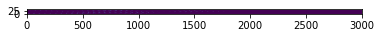

In [ ]:
#visualizing heatmpas after it has been saved to heatmap_gt.npy in Tokenpose folder
import numpy as np

data = np.load("heatmap_gt.npy")
print(np.shape(data))

import matplotlib.pyplot as plt
plt.imshow(data)
#ax = plt.gca()
#ax.set_xlim([0, 3000])
#ax.set_ylim([0, 40])
plt.show()

In [ ]:
!touch heatmap_gt.npy

In [ ]:
#testing

!python tools/test.py \
    --cfg experiments/coco/tokenpose/tokenpose_L_D24_256_192_patch43_dim192_depth24_heads12.yaml\
    TEST.MODEL_FILE /content/drive/MyDrive/*research/21_Summer_Research/TokenPose/output/coco/pose_tokenpose_l/tokenpose_L_D24_256_192_patch43_dim192_depth24_heads12/checkpoint.pth \
    TEST.USE_GT_BBOX False

# coding dataset file of h3.6

In [ ]:
%cd /content/drive/MyDrive/*learning2022/research_project/TokenPose/lib/dataset

/content/drive/MyDrive/*learning2022/research_project/TokenPose/lib/dataset


In [ ]:
!touch MocapDataset.py

In [ ]:
import numpy as np

gt_joints_path = "/content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/data_2d_h36m_gt.npz" #path of groundtruth 3d joint anotations (not converted into heatmap yet)
#joints_gt = np.load(gt_joints_path,allow_pickle=True)['positions_2d'].tolist().keys() #dict_keys(['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11'])
#joints_gt = np.load(gt_joints_path,allow_pickle=True)['positions_2d'].tolist()['S1']['Directions 1'][3][0]
joints_gt = np.load(gt_joints_path,allow_pickle=True)['positions_2d'].tolist()['S1'].keys()
print(joints_gt)
print(type(joints_gt))

'''
gt_taf_path = "/content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/h36_taf_gt.npy" #path of groundtruth taf heatmaps
taf_gt = np.load(gt_taf_path,allow_pickle=True)
print(type(taf_gt))

'''


dict_keys(['Directions 1', 'Greeting 1', 'Eating 2', 'Discussion 1', 'Phoning 1', 'Posing 1', 'Purchases 1', 'SittingDown 2', 'Smoking 1', 'Waiting 1', 'Photo 1', 'Sitting 1', 'WalkTogether 1', 'Walking 1', 'WalkDog 1', 'Discussion', 'Greeting', 'Directions', 'Eating', 'Purchases', 'Phoning', 'Posing', 'Photo', 'Walking', 'Smoking', 'Waiting', 'WalkTogether', 'Sitting 2', 'WalkDog', 'SittingDown'])
<class 'dict_keys'>


'\ngt_taf_path = "/content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/h36_taf_gt.npy" #path of groundtruth taf heatmaps\ntaf_gt = np.load(gt_taf_path,allow_pickle=True)\nprint(type(taf_gt))\n\n'

In [ ]:
x = 'S1_000007_Greeting 1.58860488.mp4'
print(x.index("_"))

import re
for i in re.finditer("_", x):
  print (i.start(), i.end())

2
2 3
9 10


[[2.1440009e-20 4.8056263e-20 1.0476411e-19 ... 1.4514761e-16
  9.3211271e-17 5.8218752e-17]
 [8.2152218e-20 1.8413909e-19 4.0142881e-19 ... 5.5616782e-16
  3.5716132e-16 2.2307910e-16]
 [3.0616196e-19 6.8624289e-19 1.4960304e-18 ... 2.0727064e-15
  1.3310509e-15 8.3136316e-16]
 ...
 [6.9452113e-07 1.5567244e-06 3.3937097e-06 ... 4.7018807e-03
  3.0194633e-03 1.8859240e-03]
 [4.8886966e-07 1.0957698e-06 2.3888094e-06 ... 3.3096250e-03
  2.1253817e-03 1.3274906e-03]
 [3.3468498e-07 7.5017471e-07 1.6354038e-06 ... 2.2658028e-03
  1.4550578e-03 9.0881390e-04]]


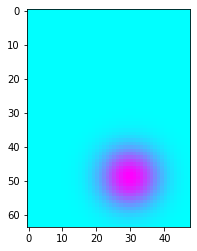

In [ ]:
import numpy as np
mu_x = 29.5562
mu_y = 48.8594
x = np.arange(0, 48, 1, np.float32)
y = np.arange(0, 64, 1, np.float32) # [0,1,2,3,4,...heatmap width]
y = y[:, np.newaxis] #[[0],[1],[2],[3],[4],...heatmap width]

#print(x)
scale = 2
#mu_x = mu_x/scale
#mu_y = mu_x/scale
z = np.exp(- ((x - mu_x) ** 2 + (y - mu_y) ** 2)/(2 * 6 ** 2)) #the 6 determinnes how big the heatmap is
print(z)
'''
print('z', z)
print(z.shape)
print(z[40])

for i in range(z.shape[0]):
  for l in range(z.shape[1]):
    if z[i][l] != 0:
      print('not zero')
'''


import matplotlib.pyplot as plt

plt.imshow(z, cmap='cool',interpolation="nearest")

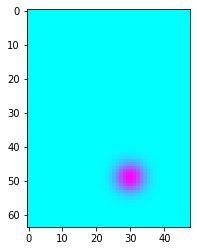

In [ ]:
import numpy as np
import scipy.stats as st

#code from https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

heatmap = gkern(12, 2)
heatmap1 = gkern(10, 2.5)

import matplotlib.pyplot as plt

plt.imshow(z, cmap='cool',interpolation="nearest")

In [ ]:
# parses throgh video data & renames images to have ex "S1_000007_Greeting 1.58860488.mp4"
# need to do again when more subjects get added in

import os

root = "/content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/H36_video_data"
subjects_list = os.listdir(root)
print("subjects_list:",subjects_list)
index = 0
for subject_name in subjects_list:
  videos_list = os.listdir(os.path.join(root,subject_name))
  print("videos_list:",videos_list)
  for video_name in videos_list:
    source = os.path.join(root, subject_name, video_name)
    video_index = '%06d' %index
    '''
    video_name_new = video_index + "_" + video_name
    dest = os.path.join(root, subject_name, video_name_new)
    '''
    video_name_new = subject_name + "_" + video_index + "_" + video_name #be aware that the video_name is the orginal name so it will add on a S1_00000233_ instead of changing it out
    dest = os.path.join(root, subject_name, video_name_new)
    os.rename(source, dest)
    print("renamed from :",source)
    print("to:", dest)
    index +=1

'''Sample Results:
renamed from : /content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/H36_image_data/H36_S1_50fps/Discussion.55011271.mp4
to: /content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/H36_image_data/H36_S1_50fps/000039_Discussion.55011271.mp4

'''

subjects_list: ['S1']
videos_list: ['Greeting.54138969.mp4', 'Greeting.60457274.mp4', 'Greeting 1.54138969.mp4', 'Greeting 1.60457274.mp4', 'Greeting.58860488.mp4', 'Directions 1.60457274.mp4', 'Directions 1.54138969.mp4', 'Greeting 1.58860488.mp4', 'Greeting.55011271.mp4', 'Directions 1.55011271.mp4', 'Greeting 1.55011271.mp4', 'Directions.55011271.mp4', 'Directions.58860488.mp4', 'Directions 1.58860488.mp4', 'Directions.60457274.mp4', '_ALL.58860488.mp4', '_ALL.60457274.mp4', 'Directions.54138969.mp4', '_ALL 1.55011271.mp4', '_ALL 1.60457274.mp4', '_ALL.55011271.mp4', '_ALL 1.58860488.mp4', '_ALL.54138969.mp4', '_ALL 1.54138969.mp4', 'Eating 2.58860488.mp4', 'Eating 2.55011271.mp4', 'Eating 2.54138969.mp4', 'Eating.60457274.mp4', 'Eating.55011271.mp4', 'Eating 2.60457274.mp4', 'Eating.54138969.mp4', 'Eating.58860488.mp4', 'Discussion 1.54138969.mp4', 'Discussion 1.55011271.mp4', 'Discussion 1.60457274.mp4', 'Discussion.58860488.mp4', 'Discussion.54138969.mp4', 'Discussion.60457274.mp

'Sample Results:\nrenamed from : /content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/H36_image_data/H36_S1_50fps/Discussion.55011271.mp4\nto: /content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/H36_image_data/H36_S1_50fps/000039_Discussion.55011271.mp4\n\n'

In [ ]:
import os

root = "/content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/H36_image_data"

total_video_list = []
subjects_list = os.listdir(root)
for subject in subjects_list:
  subject_videos_list = os.listdir(os.path.join(root,subject))
  total_video_list.extend(subject_videos_list)
print(total_video_list)

['000000_Greeting.54138969.mp4', '000001_Greeting.60457274.mp4', '000002_Greeting 1.54138969.mp4', '000003_Greeting 1.60457274.mp4', '000004_Greeting.58860488.mp4', '000005_Directions 1.60457274.mp4', '000006_Directions 1.54138969.mp4', '000007_Greeting 1.58860488.mp4', '000008_Greeting.55011271.mp4', '000009_Directions 1.55011271.mp4', '000010_Greeting 1.55011271.mp4', '000011_Directions.55011271.mp4', '000012_Directions.58860488.mp4', '000013_Directions 1.58860488.mp4', '000014_Directions.60457274.mp4', '000015__ALL.58860488.mp4', '000016__ALL.60457274.mp4', '000017_Directions.54138969.mp4', '000018__ALL 1.55011271.mp4', '000019__ALL 1.60457274.mp4', '000020__ALL.55011271.mp4', '000021__ALL 1.58860488.mp4', '000022__ALL.54138969.mp4', '000023__ALL 1.54138969.mp4', '000024_Eating 2.58860488.mp4', '000025_Eating 2.55011271.mp4', '000026_Eating 2.54138969.mp4', '000027_Eating.60457274.mp4', '000028_Eating.55011271.mp4', '000029_Eating 2.60457274.mp4', '000030_Eating.54138969.mp4', '0000

In [ ]:
index = 223
x = '%06d'% index
print(x)

000223


In [ ]:
s = '_ALL.55011271.mp4'
s_new = s[2:-13]

subject_name = 'H36_S1_50fps'
subject = subject_name[4:-6]
print(s_new)

print(subject)

LL
S1


In [ ]:
import pathlib
s = 'Discussion.55011271.mp4_frame2.jpg'
print(pathlib.Path(s).with_suffix(""))

print(s.index('frame') + 5)

s = '2'
print(int(s))

Discussion.55011271.mp4_frame2
29
2


# Generating images from Human3.6 videos at 50fps: (only generated for part 1 of S1 videos so far)

In [ ]:
%cd Videos #in order to run the next command, current directory needs to be in ../data/Videos

/content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/Videos


In [ ]:
!python /content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/h36_vid_to_image.py

Greeting.54138969.mp4
Greeting.60457274.mp4
Greeting 1.54138969.mp4
Greeting 1.60457274.mp4
Greeting.58860488.mp4
Directions 1.60457274.mp4
Directions 1.54138969.mp4
Greeting 1.58860488.mp4
Greeting.55011271.mp4
Directions 1.55011271.mp4
Greeting 1.55011271.mp4
Directions.55011271.mp4
Directions.58860488.mp4
Directions 1.58860488.mp4
Directions.60457274.mp4
_ALL.58860488.mp4
_ALL.60457274.mp4
Directions.54138969.mp4
_ALL 1.55011271.mp4
_ALL 1.60457274.mp4
_ALL.55011271.mp4
_ALL 1.58860488.mp4
_ALL.54138969.mp4
_ALL 1.54138969.mp4
Eating 2.58860488.mp4
Eating 2.55011271.mp4
Eating 2.54138969.mp4
Eating.60457274.mp4
Eating.55011271.mp4
Eating 2.60457274.mp4
Eating.54138969.mp4
Eating.58860488.mp4
Discussion 1.54138969.mp4
Discussion 1.55011271.mp4
Discussion 1.60457274.mp4
Discussion.58860488.mp4
Discussion.54138969.mp4
Discussion.60457274.mp4
Discussion 1.58860488.mp4
Discussion.55011271.mp4
Done generating images!


In [ ]:
%cd /content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/

/content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data


In [ ]:
!python h36_vid_to_image.py

S5
Done generating images!


In [ ]:
## code also in h36_vid_to_image.py in /content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data

import cv2
import os

video_list = os.listdir('/content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/Videos/') #define list of videos to turn into images
master_folder_save_path = "/content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/H36_Images_50fps/"
#video_list = video_list[0:2]

def getFrame(sec, vid:str, vid_cap, frame:int, save_path:str):
    vid_cap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vid_cap.read()
    if hasFrames:
        path = os.path.join(save_path, vid+"_frame"+str(frame)+".jpg")
        print(path)
        cv2.imwrite(path, image)     # save frame as JPG file
    return hasFrames

for vid in video_list: #for string in list of videos
  dir = os.path.join(master_folder_save_path + vid) #creates a new folder for each video
  if not os.path.exists(dir):
    os.mkdir(dir)
  vidcap = cv2.VideoCapture(vid)
  sec = 0
  frameRate = 0.02 #//it will capture image in each 0.02 second --> so 50 images per sec = 50fps
  frame=0
  success = getFrame(sec, vid, vidcap, frame, dir)
  while success:
      frame = frame + 1
      sec = sec + frameRate
      sec = round(sec, 2)
      success = getFrame(sec, vid, vidcap, frame, dir)
      
print("done")

#creating 50,000 images --> assume 25 sec per vid * 50 fps * 40 vids = 50,000 images -- honestly, average is more that 25 sec
#took 1hr 13 min for S1 part 1 videos




# Downsizing / manipulating image data

checking the image resolution, size, possibly downsize


image size is (1000,1000,3)

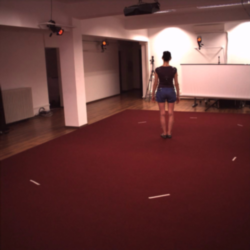

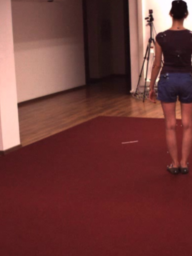

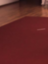

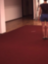

In [ ]:
#checking image resolution, size, trying to downsize --> probably should keep it at (1000,1000,3)
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#path = '/content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/H36_video_data/S1/S1_000026_Eating 2.54138969.mp4/Eating 2.54138969.mp4_frame1.jpg'
path = '/content/drive/MyDrive/*learning2022/research_project/TokenPose/lib/VideoPose3D/data/H36_video_data/train_set/S1/S1_000000_Greeting.58860488.mp4/Greeting.58860488.mp4_frame0.jpg'
img = cv2.imread(path)
img_down = cv2.pyrDown(img)
img_down2 = cv2.pyrDown(img_down)
img_down3 = cv2.pyrDown(img_down2)
cropped = img_down[372:628,404:596]
cropped2 = img_down[122:378,154:346]
cropped3 = img_down[102:398,134:366]
# pyrDown half for everything and remove the boarders
cropped4 = img_down[98:402,136:364] ###final decided size (304,228). (1000,1000)--pyrdown (gaussian image pyramid)-->(500,500) --crop the sides--> (304,228)


cropped5 = img_down[122:378,154:346]
cropped6 = img_down[102:358,154:346] ##final (img size 256 * 192)
cropped61 = img_down2[93:157,101:149] # heatmap size 64 * 48
cropped62 = img_down3[30:94, 38:86]
cropped7 = img_down[92:348,174:366]
#transforms = transforms.CenterCrop((192,256))
#img = transforms(img)

#img = img.crop((192,256))
#print(img.shape) #(1000, 1000, 3)
#cv2_imshow(img)
#img_down = cv2.pyrDown(img)
#img_down = cv2.pyrDown(img)
#img_down = cv2.pyrDown(img_down)
#img_down = cv2.pyrDown(img_down)
#print(img_down.shape)
#cv2_imshow(img)
#cv2_imshow(cropped5)
cv2_imshow(img_down2)
cv2_imshow(cropped6)
cv2_imshow(cropped61)
cv2_imshow(cropped62)
#cv2_imshow(cropped7)
#cv2_imshow(img_down)
#cv2_imshow(cropped) #(500,500,3)
#cv2_imshow(cropped3)
#cv2_imshow(cropped4)

#4 x 1265 x 17 x2


# Generating Human3.6 GT Temporal Affinity Fields Maps




In [ ]:
%cd /content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/

/content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data


In [ ]:
!touch taf_gt.json

In [ ]:
import numpy as np
path = '/content/drive/MyDrive/*learning2022/research_project/TokenPose/lib/VideoPose3D/data/H36_taf_gt/S1/Eating 2/vid0.npy'
x = np.load(path)
print(x.shape) # print out the shape of taf gt file shape = (322, 17, 64, 48, 2) --> (frames, joints, 64, 48, 2)

(471, 17, 64, 48, 2)


taf map size is torch.Size([64, 48, 2])

In [ ]:
!python /content/drive/MyDrive/*learning2022/research_project/TokenPose/lib/VideoPose3D/data/h36_taf_gt_generator.py

In [ ]:
for i in range(0,5-2,2):
  print(i)

0
2


In [ ]:
import numpy as np
import torch
x1 = torch.rand((9, 17, 48, 64))
x1reshaped = x1.reshape((9, 17, -1)).split(1,1) #w/o .split
print(len(x1reshaped))
x2 = torch.rand((9, 20, 17, 48, 64))
x2reshaped = x2.reshape((9, 20, 17,-1)).split(1,1)
#print(x2reshaped.shape)
print(len(x2reshaped))
x = torch.tensor(([[[[3,2],[2,1],[4,7]],[[3,7],[4,6],[6,4]]]]))
y = torch.tensor([1,2,3])
#print(x.split(1,1))
#print(x1)

17
20


In [ ]:
import torch

x = torch.cuda.FloatTensor((2,3))
y = torch.cuda

In [ ]:

#'/content/drive/MyDrive/*learning2022/research_project/TokenPose/lib/VideoPose3D/data/h36_taf_gt_generator.py'

Generate the ACTUAL ground truth TAF maps 

* shape: (1000,1000,2)
* ```
STRUCTURE: taf_gt[subject][action][vid][taf_frames][joints][x_coordinate_pixel][y_coordinate_pixel][either 0 or 1 for x_i or y_j components] 
  ```


* result_taf_gt is the dictionary that stores all of the TAF maps --> need to generate taf for all Subjects & actions --> do when more data is available




In [ ]:
#code inside h36_taf_gt_generator.py in /content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data

def xyt_retriever(subject:str, action:str, video_number:int, start_frame:int, end_frame:int):
  path = '/content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/data_2d_h36m_gt.npz'
  data = np.load(path, allow_pickle=True) #loading the npz file
  data1 = data['positions_2d'].tolist()[subject][action][video_number-1][start_frame:end_frame+1] 

  xs = []
  ys = []
  zs = [] #time axis
  #ax = plt.axes(projection='3d') 
  for frames in range(len(data1)):  
    temp_xs = []
    temp_ys = []
    temp_zs = []
    for joints in range(len(data1[frames])):
      temp_xs.append(data1[frames][joints][0])
      temp_ys.append(data1[frames][joints][1])
      temp_zs.append(frames)
      #ax.scatter(xs, ys, zs, color='darkblue', linewidth=0.01) #plot plot
  
    xs.append(temp_xs)
    ys.append(temp_ys)
    zs.append(temp_zs)
  return xs, ys, zs #len(xs) is the amount of frames & x[frames][joints] = values at each joint # ex: 3

#print(x)

def compute_TAF(x, y, z, map_length=1000, map_width=1000, frame_sample_rate=1): #Computes TAF from x, y, z ground truths(all of which are 2D arrays e.g x[frames][x_vals])) 
  taf_gt_maps = []

  taf_frame_num = len(x)
  for taf_frames in range(0,taf_frame_num-1, frame_sample_rate):
    taf_frames_gt_maps = []

    for joints in range(0, len(x[0])):
      taf_joint_gt_map = np.zeros((map_length, map_width, 2)) #define map for cur joint in cur taf_frame
      '''
      x_pt1 = x[taf_frames][joints]
      #x_pt2 = x[taf_frames+50][joints] #the next sample in the taf is a second later
      x_pt2 = x[taf_frames+frame_sample_rate][joints]
      y_pt1 = y[taf_frames][joints]
      y_pt2 = y[taf_frames+frame_sample_rate][joints]
      '''
      x_pt1 = round(x[taf_frames][joints])
      #x_pt2 = x[taf_frames+50][joints] #the next sample in the taf is a second later
      x_pt2 = round(x[taf_frames+frame_sample_rate][joints])
      y_pt1 = round(y[taf_frames][joints])
      y_pt2 = round(y[taf_frames+frame_sample_rate][joints])
      
      z_pt1 = z[taf_frames][joints]
      z_pt2 = z[taf_frames+frame_sample_rate][joints]

      x_i = x_pt2 - x_pt1 #i-component of TAF vector
      y_j = y_pt2 - y_pt1 #j-component of TAF vector
      #print("tafframes:",taf_frames," joints:",joints," x_pt1:",x_pt1," y_pt1:",y_pt1," x_pt2:",x_pt2," y_pt2:",y_pt2," x_i:",x_i," y_j:",y_j)

      if -1 <= abs(x_i) <= 1:
        Nx = 2
      else:
        Nx = abs(x_i) + 2

      if -1 <= abs(y_j) <= 1:
        Ny = 2
      else:
        Ny = abs(y_j)

      #creating mid-points coordinates to plot (the same x_i & y_j) if the x1 & x2 points are far away
      x_list = np.linspace(x_pt1, x_pt2, max(Nx,Ny), dtype = int)
      y_list = np.linspace(y_pt1, y_pt2, max(Nx,Ny), dtype = int)
      #print(x_list)
      #print(y_list)

      for a in x_list: #x_list is the same length as y_list, so it doesn't matter
        for b in y_list:
          taf_joint_gt_map[a][b][0] = x_i #append the TAF vector components to the correct index in the affinity map
          taf_joint_gt_map[a][b][1] = y_j

      #append maps for each joint to maps for each taf_frame 
      taf_frames_gt_maps.append(taf_joint_gt_map)      
    taf_gt_maps.append(taf_frames_gt_maps)
  return np.array(taf_gt_maps)


def generte_TAF(subject:str, action:str, total_vid_num:int, start_frame:int, end_frame:int): #current incomplete:
  taf_gt = {}

  subject_list = ["S1","S5","S6","S7","S8","S9","S11"]
  #not done!

  taf_gt[subject] = {}
  taf_gt[subject][action] = []

  for video_number in range(total_vid_num):
    x, y, z = xyt_retriever(subject, action, video_number+1, start_frame, end_frame)
    taf_gt_maps = compute_TAF(x, y, z)
    taf_gt[subject][action].append(taf_gt_maps)

  taf_gt[subject][action] = np.array(taf_gt[subject][action])
    ##Notes:
    #STRUCTURE: taf_gt[subject][action][vid][taf_frames][joints][x_coordinate_pixel][y_coordinate_pixel][either 0 or 1 for x_i or y_j components]
    #len(taf_gt[subject][action][vid]) is = taf_frames, which is the number of taf maps for the amount of frames passed in. ex: if frames = 4, them taf_frames = 3 bec we can only make 3 taf maps for 4 frames
  
  print(taf_gt[subject][action][3][3][11][521][246]) #expect x_i: 7 y_j: -4 --> works!!
    #tafframes: 3 joints: 11 x_pt1: 514 y_pt1: 250 x_pt2: 521 y_pt2: 246 x_i: 7 y_j: -4

def generate_TAF_subject_action(subject:str, action:str, total_vid_num:int, start_frame:int, end_frame:int):
  taf_gt = {}
  taf_gt[subject] = {}
  taf_gt[subject][action] = []

  for video_number in range(total_vid_num):
    x, y, z = xyt_retriever(subject, action, video_number+1, start_frame, end_frame)
    taf_gt_maps = compute_TAF(x, y, z)
    taf_gt[subject][action].append(taf_gt_maps)

  taf_gt[subject][action] = np.array(taf_gt[subject][action])
    ##Notes:
    #STRUCTURE: taf_gt[subject][action][vid][taf_frames][joints][x_coordinate_pixel][y_coordinate_pixel][either 0 or 1 for x_i or y_j components]
    #len(taf_gt[subject][action][vid]) is = taf_frames, which is the number of taf maps for the amount of frames passed in. ex: if frames = 4, them taf_frames = 3 bec we can only make 3 taf maps for 4 frames
  
  print(taf_gt[subject][action][3][3][11][521][246]) #expect x_i: 7 y_j: -4 --> works!!
    #tafframes: 3 joints: 11 x_pt1: 514 y_pt1: 250 x_pt2: 521 y_pt2: 246 x_i: 7 y_j: -4

  return taf_gt

  
result_taf_gt = generate_TAF_subject_action("S1", "Greeting 1", total_vid_num = 4, start_frame =0, end_frame = 4)

#np.savez("/content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/h36_taf_gt.npy",result_taf_gt, allow_pickle=True) #np array is too big
np.savez("/content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/h36_taf_gt.npy",result_taf_gt["S1"]["Greeting 1"], allow_pickle=True)




In [ ]:
#np.savez_compressed("/content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/h36_taf_gt.npz",result_taf_gt, allow_pickle=True)
np.save("/content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/h36_taf_gt.npy",result_taf_gt["S1"]["Greeting 1"], allow_pickle=True)

#### the numpy array result_taf_gt is too big to save , result_taf_gt["S1"]["Greeting 1"] is fine tho

In [ ]:
path= "/content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/h36_taf_gt.npy"
data = np.load(path)
print(data.shape)

(4, 4, 17, 1000, 1000, 2)


# Next steps:

---


> try to load the numpy files into Tokenpose, see what coco does --> shouldn't do this --> done

> how will i call the images of multiple frames to find the loss? --> pass videos in instead of frames --> done

> change image input size back to the original in cfg file, run --> done

> 6/6: **keep on debugging: current bug: indexing is not right for taf_all_frames = np.array(self.taf_gt[subject][action][video_number]) --> need to seperately load the taf gt npz file to see how things were saved!!!!!!!**

>  change the target weight indexing and taf indexing as  well in h36.py

In [ ]:
#loading taf ground truth to check

path =  '/content/drive/MyDrive/*learning2022/research_project/VideoPose3D/data/h36_taf_gt.npy'
import numpy as np

taf_gt = np.load(path)
print(type(taf_gt))
print(taf_gt.shape)
print(type(taf_gt[0][0][0][0][0]))

<class 'numpy.ndarray'>
(4, 4, 17, 1000, 1000, 2)
<class 'numpy.ndarray'>


# Dataloader for H3.6 

In [ ]:
%cd  /content/drive/MyDrive/*learning2022/research_project/TokenPose/lib/dataset

/content/drive/MyDrive/*learning2022/research_project/TokenPose/lib/dataset


In [ ]:
%cd ..

/content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master


In [ ]:
#%cd /content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data
!python run.py --dataset h36m --keypoints gt
#ran in 2hr 23 mins

Namespace(actions='*', architecture='3,3,3', batch_size=1024, bone_length_term=True, by_subject=False, causal=False, channels=1024, checkpoint='checkpoint', checkpoint_frequency=10, data_augmentation=True, dataset='h36m', dense=False, disable_optimizations=False, downsample=1, dropout=0.25, epochs=60, evaluate='', export_training_curves=False, keypoints='gt', learning_rate=0.001, linear_projection=False, lr_decay=0.95, no_eval=False, no_proj=False, render=False, resume='', stride=1, subjects_test='S9,S11', subjects_train='S1,S5,S6,S7,S8', subjects_unlabeled='', subset=1, test_time_augmentation=True, viz_action=None, viz_bitrate=3000, viz_camera=0, viz_downsample=1, viz_export=None, viz_limit=-1, viz_no_ground_truth=False, viz_output=None, viz_size=5, viz_skip=0, viz_subject=None, viz_video=None, warmup=1)
Loading dataset...
Preparing data...
Loading 2D detections...
INFO: Receptive field: 27 frames
INFO: Trainable parameter count: 8555571
INFO: Testing on 543344 frames
INFO: Training o

# Human 3.6 Dataset Preparation

Unzipping the videos

In [ ]:
# unzip Human 3.6 videos in the right directory
%cd /content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/Videos
!unzip Videos_S1_part1.zip

Converting the CDF ground truth files into loadable pytorch's npz files

In [ ]:
%cd /content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master

/content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master


In [ ]:
#generates data_3d_h36m.npz and data_2d_h36m_gt.npz from data/Poses/S#/CDF files
#--> specific formatting of dictionaries saved to the npz files are specified in prepare_data_h36m.py
#--> directions link: https://github.com/facebookresearch/VideoPose3D/blob/main/DATASETS.md#instructions-without-matlab-recommended
#%cd data
!pip install cdflib
!python prepare_data_h36m.py --from-source-cdf /content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/Poses
#%cd ..

Converting original Human3.6M dataset from /content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/Poses (CDF files)
Saving...
Done.

Computing ground-truth 2D poses...
Saving...
Done.


# Human 3.6 GT Data Visualition

The two cells below are two options to generate graphs of the ground truth poses for Human 3.6



```
#ex
get_vis_h36_gt('S1','Directions',1,start_frame=0,end_frame=1)

```


Arguments
*   Subject name
*   Action name
*   Video number (there are four per action)
*   Starting frame: first frame grapher out
*   End frame: last frame to be graphed out

Sample graphs are shown below.



In [ ]:
#OPTION 1: run file & method 
#can run from any directory --> defaultly runs get_vis_h36_gt('S1','Directions',1,start_frame=0,end_frame=1)
!python /content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/visualization.py


Graphs created in /content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/Pose_Vis


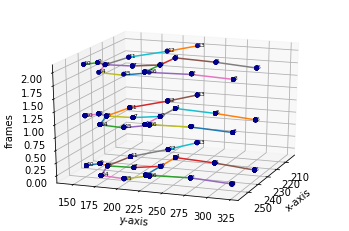

In [ ]:
#OPTION 2: inline plt.show()
import numpy as np

path = '/content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/data_2d_h36m_gt.npz'
data = np.load(path, allow_pickle=True) #loading the npz file
data1 = data['positions_2d'].tolist()['S1']['Directions'][0][20:23]

#print(data1)
#print(len(data1))
#print(data1)
#print(type(data1))

#defining 16 limbs - in tems of first limb = 0
keypoint_pairing = {
    'face':[9,10],
    "neck": [8,9],
    "torso1": [7,8],
    "torso2": [0,7],
    "l_sh": [8,14],
    "r_sh": [8,11],
    "l_u_arm": [14,15],
    "r_u_arm": [11,12],
    "l_l_arm": [15,16],
    "r_l_arm": [12, 13],
    "l_hip": [0,1],
    "r_hip": [0,4],
    "l_thigh": [1,2],
    "r_thigh": [4,5],
    "l_calf": [2,3],
    "r_calf": [5,6]
}

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

xs = []
ys = []
zs = [] #time axis

ax = plt.axes(projection='3d',) #initialize plot

for frames in range(len(data1)):
  for joints in range(len(data1[frames])):
    #if joints == 1:
      #ax.scatter(xs = data1[frames][joints][0], ys = data1[frames][joints][1],zs = frames, color='red')
    #xs.append(data1[frames][joints][0])
    #ys.append(data1[frames][joints][1])
    xs.append(data1[frames][joints][0]/2)
    ys.append(data1[frames][joints][1]/2)
    zs.append(frames)
    #ax.scatter(xs, ys, zs, c=zs, cmap='viridis', linewidth=1, label=str(joints)) #plot plot
    ax.scatter(xs, ys, zs, color='darkblue', linewidth=0.2) #plot plot
    text = str(joints)
    ax.text(x=xs[-1], y=ys[-1], z=frames, s=text, fontsize=6) #labels at the joints with corresponding joint number

  for key, values in keypoint_pairing.items():
    x_j1 = xs[values[0]]
    x_j2 = xs[values[1]]
    y_j1 = ys[values[0]]
    y_j2 = ys[values[1]]
    x = np.linspace(x_j1,x_j2) #creates a line (array of points) between the specified point values
    y = np.linspace(y_j1,y_j2)
    ax.plot3D(x,y,frames)

#ax.scatter(xs, zs, ys)
#ax.scatter(xs, ys, zs, c=zs, cmap='viridis', linewidth=1) #plot plot

ax.set_xlabel("x-axis",fontsize='10',linespacing=3.5)
ax.set_ylabel("y-axis",fontsize='10',linespacing=3.5)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel("frames",fontsize='10',rotation=90)

#ax.set_xlim(200,700)
#ax.set_zlim(0,10)
#ax.set_ylim(200,700)

ax.view_init(20, 20) #shows x,y axis view
#plt.savefig("output.jpg")
plt.show()

# Older version of Human 3.6 visualization

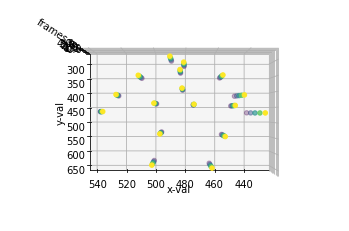

In [ ]:
##version 1 - only plots the keypoints, no labels, no limbs
#!python /content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/visualization.py

import numpy as np

path = '/content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/data_2d_h36m_gt.npz'
data = np.load(path, allow_pickle=True) #loading the npz file
data1 = data['positions_2d'].tolist()['S1']['Directions'][0][:5]

#print(data1)
#print(len(data1))
#print(data1)
#print(type(data1))

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

xs = []
ys = []
zs = [] #time axis

ax = plt.axes(projection='3d') #initialize plot

for frames in range(len(data1)):
  for joints in range(len(data1[frames])):
    xs.append(data1[frames][joints][0])
    ys.append(data1[frames][joints][1])
    zs.append(frames)

#ax.scatter(xs, zs, ys)

#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(xs,zs,ys, color = 'black') # plot the point (2,3,4) on the figure

ax.scatter(xs, ys, zs, c=zs, cmap='viridis', linewidth=1) #plot plot
#ax.plot(ys, xs, ys)

ax.set_xlabel("x-val")
ax.set_ylabel('y-val')
ax.set_zlabel("frames")

#ax.set_xlim(300,600)
#ax.set_zlim(0,10)
#ax.set_ylim(300,600)


ax.view_init(90, 90) #shows x,y axis view
plt.show()

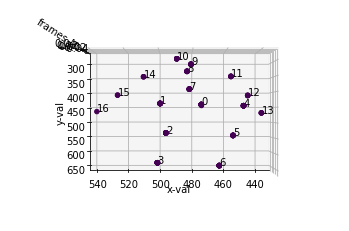

In [ ]:
##version 2 - plots the keypoints and labels, no limbs

#!python /content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/visualization.py

import numpy as np

path = '/content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data/data_2d_h36m_gt.npz'
data = np.load(path, allow_pickle=True) #loading the npz file
data1 = data['positions_2d'].tolist()['S1']['Directions'][0][:1]

#print(data1)
#print(len(data1))
#print(data1)
#print(type(data1))

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

xs = []
ys = []
zs = [] #time axis

ax = plt.axes(projection='3d') #initialize plot

for frames in range(len(data1)):
  for joints in range(len(data1[frames])):
    #if joints == 1:
      #ax.scatter(xs = data1[frames][joints][0], ys = data1[frames][joints][1],zs = frames, color='red')
    xs.append(data1[frames][joints][0])
    ys.append(data1[frames][joints][1])
    zs.append(frames)
    ax.scatter(xs, ys, zs, c=zs, cmap='viridis', linewidth=1, label=str(joints)) #plot plot
    text = str(joints)
    ax.text(x=xs[-1], y=ys[-1], z=frames, s=text)

#ax.scatter(xs, zs, ys)

#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(xs,zs,ys, color = 'black') # plot the point (2,3,4) on the figure

#ax.scatter(xs, ys, zs, c=zs, cmap='viridis', linewidth=1) #plot plot
#ax.plot(ys, xs, ys)

ax.set_xlabel("x-val")
ax.set_ylabel('y-val')
ax.set_zlabel("frames")

#ax.set_xlim(200,700)
#ax.set_zlim(0,10)
#ax.set_ylim(200,700)

ax.view_init(90, 90) #shows x,y axis view
plt.show()

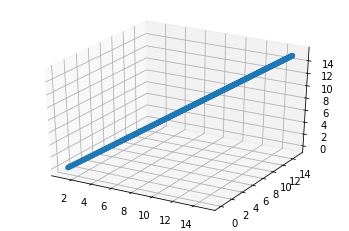

In [ ]:
#random example for plotting lines using np.linspaces(x,y) --> ignore!
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plot = plt.axes(projection='3d')
x = np.linspace(1, 15, 1000)
y = np.linspace(0, 15, 1000)
z = np.linspace(0, 15, 1000)
plot.scatter(x, y, z)
plt.show()

#np.linspace(0, 15, 1000)

In [ ]:
%cd /content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data

/content/drive/MyDrive/*learning2022/research_project/VideoPose3D-master/data


# MPII Dataset

# TokenPose code download folder preparation (only run once) - ran

In [ ]:
''' already did once

# COCOAPI=/path/to/clone/cocoapi
!git clone https://github.com/cocodataset/cocoapi.git $COCOAPI
%cd cocoapi/PythonAPI
# Install into global site-packages
!make install
# Alternatively, if you do not have permissions or prefer
# not to install the COCO API into global site-packages
!python3 setup.py install --user
'''

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 15.22 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/drive/My Drive/*research/21_Summer_Research/TokenPose/cocoapi/PythonAPI
# install pycocotools to the Python site-packages
python setup.py build_ext install
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/My Drive/*research/21_Summer_Research/TokenPose/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu

In [ ]:
#%cd ..

/content/drive/MyDrive/*research/21_Summer_Research/TokenPose


In [ ]:
!pwd
#needs to be in tokenpose

/content/drive/My Drive/*research/21_Summer_Research/TokenPose


In [ ]:
#needs to be in lib/nms but only needs to do once

!python setup_linux.py build_ext --inplace

python3: can't open file 'setup_linux.py': [Errno 2] No such file or directory


In [ ]:
##check if gpu is working --> should return Found GPU at: /device:GPU:0
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# COCO Dataset download & unzip (only run once) - ran


In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip

--2021-10-11 00:04:46--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.96.60
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.96.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  41.5MB/s    in 32m 4s  

2021-10-11 00:36:51 (9.58 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [ ]:
!unzip train2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: train2017/000000259556.jpg  
 extracting: train2017/000000381931.jpg  
 extracting: train2017/000000569592.jpg  
 extracting: train2017/000000229396.jpg  
 extracting: train2017/000000488990.jpg  
 extracting: train2017/000000348684.jpg  
 extracting: train2017/000000234031.jpg  
 extracting: train2017/000000563584.jpg  
 extracting: train2017/000000276069.jpg  
 extracting: train2017/000000401194.jpg  
 extracting: train2017/000000502089.jpg  
 extracting: train2017/000000192183.jpg  
 extracting: train2017/000000425127.jpg  
 extracting: train2017/000000126766.jpg  
 extracting: train2017/000000324161.jpg  
 extracting: train2017/000000452746.jpg  
 extracting: train2017/000000423782.jpg  
 extracting: train2017/000000546343.jpg  
 extracting: train2017/000000249290.jpg  
 extracting: train2017/000000025529.jpg  
 extracting: train2017/000000316928.jpg  
 extracting: train2017/000000337866.jpg  
 extracting: train2017/00

# random code examples

In [ ]:
#class example
class Fish():
  def __init__(self):
    self.home = "corals"

  def sum(self,num1,num2):
    return num1 + num2

class goldFish(Fish):
  def __init__(self):
    super().__init__()
    self.home = "the sea"

emily = Fish()
jackie = goldFish()
print(jackie.sum(1,2))
print(jackie.home)


3
the sea


In [ ]:
# random example code for pytorch backpropagation --> not completely converted to pytorch tho
import torch

x = torch.randn(3, requires_grad=True)
print(x)

y = x+2
z = y.mean()

print(y)
print(type(y))

y.backward()
print(x.grad)


